# Bayesian Hierarchical Linear Regression Exercises

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

az.style.use("arviz-darkgrid")
np.set_printoptions(2)

fish_market = pd.read_csv("data/fish-market.csv")
fish_market = fish_market.drop(["Length2", "Length3"], axis="columns")
fish_market["log_width"] = np.log(fish_market.Width)
fish_market["log_height"] = np.log(fish_market.Height)
fish_market["log_length"] = np.log(fish_market.Length1)
fish_market["log_weight"] = np.log(fish_market.Weight)
fish_reduced = fish_market[fish_market["Weight"] != 0].copy()

species_idx, species = fish_reduced.Species.factorize(sort=True)
COORDS = {"species": species}

/home/oriol/bin/miniforge3/envs/intuitive_bayes/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Exercise 1: Real world examples of hierarchies

> In the lesson we mentioned that nested and grouped data is very common. Think of 5 real-world examples where hierarchical models would be a good fit. Bonus points if some examples come from data sets you worked with.

Remember that in this exercise there's no good or bad answer. Even if your ideas were different than the ones you see here, you've done great! The purpose of this exercise was for you to stop and think about what you've learned about hierarchies, and what you could use it for. So once again, good job and keep going!

1. Medical diagnosis: A Bayesian hierarchical model could be used to identify the most likely disease based on symptoms, patient history, and lab test results [(link to study)](https://onlinelibrary.wiley.com/doi/abs/10.1002/env.571).
1. Weather forecasting: A Bayesian hierarchical model could be used to make more accurate weather predictions by incorporating data from multiple sources, such as radar, satellite, and ground-based observations [(link to study)](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.767).
1. Marketing: A Bayesian hierarchical model could be used to analyze customer data and identify segments of customers who are most likely to respond to a particular marketing campaign [(link to study)](https://journals.sagepub.com/doi/pdf/10.1177/0022243720952410).
1. Natural Language Processing: A Bayesian hierarchical model can be used to model the probability of a word given the preceding words in a sentence, this is called topic modeling [(link to study)](https://aclanthology.org/E14-1006.pdf).
1. Financial Risk Management: A Bayesian hierarchical model can be used to analyze financial data, such as market trends and historical performance, to identify potential risks and make more informed investment decisions [(link to study)](https://www.sciencedirect.com/science/article/pii/S2667096822000647).


## Exercise 2: Explore Distributions Over Parameters

> In this exercise we want to build stronger intuitions around what the different parameters of the model do. Towards this goal, you will generate plots using different settings and analyzing the outputs.
Specifically, try the following settings and describe what changed:
> * global_mu = -0.5 ; global_sigma = 1 ; local_sigma = 0.1 ; n_local = 8
> * global_mu = 0.0 ; global_sigma = 0.5 ; local_sigma = 0.5 ; n_local = 8
> * global_mu = 0.0 ; global_sigma = 0.5 ; local_sigma = 0.1 ; n_local = 16
> * global_mu = 0.0 ; global_sigma = 10. ; local_sigma = 0.1 ; n_local = 8
> * global_mu = 0.0 ; global_sigma = 0.001 ; local_sigma = 0.1 ; n_local = 8

In [2]:
def gen_hier_plot(mu=0, sigma=0.5, eps=0.1, groups=8, seed=2):
    """
    Sample hierarchical data and plot it.
    """
    from scipy import stats
    from numpy.random import default_rng

    rng = default_rng(seed)
    
    group_dist = stats.norm(mu, sigma)
    mus = group_dist.rvs(groups, random_state=rng)
    data = stats.norm(mus, eps).rvs(size=(1000, groups), random_state=rng)
    x = np.linspace(data.min() - .5, data.max() + .5, 1000)

    fig, axs = plt.subplots(nrows=2, sharex=True)
    pdf = group_dist.pdf(x)
    axs[0].plot(x, pdf)
    axs[0].set(title=f"global distribution\nmu={mu} sigma={sigma}, eps={eps}, groups={groups}", ylabel="Belief")
    axs[1].set(title="local distributions", xlabel="x", ylabel="Belief")
    for i in range(groups):
        color = sns.color_palette(n_colors = groups)[i]
        axs[0].plot(mus[i], 0, ".", ms=8, color=color)
        az.plot_dist(data[:, i], color=color, ax = axs[1])

As it's the very first example I'll treat it as a baseline, in general we can see that `mu` influences
the center of the chart, global sigma ( here marked as `sigma` ) is responsible for spread of local distributions,
as it's a main boundary for our global trend, defining it's width. Local sigmas (`eps`) define widths of local
distributions. The combination of `sigma` and `eps` parameters defines how much the distributions overlap.

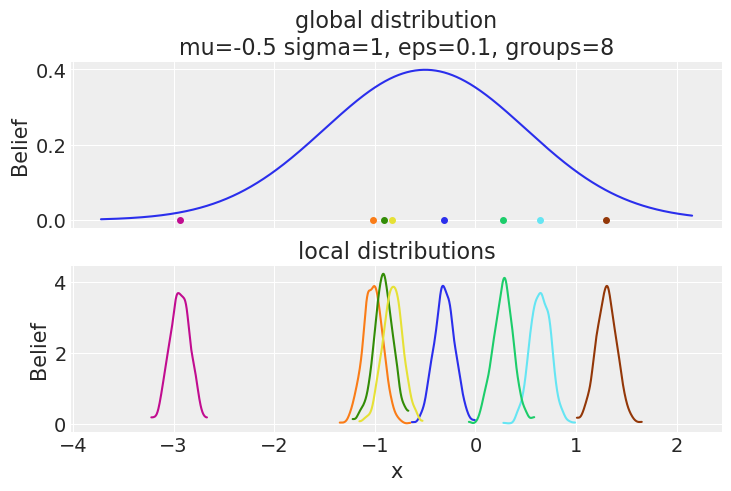

In [3]:
gen_hier_plot(mu = -0.5, sigma = 1, eps = 0.1)

As mentioned above , sigma defines width of the global dist. so making it smaller pulls the local distributions
more closely together. Higher value for eps makes them wider, which causes much more overlap.

Changing mu moves the center of global dist to the middle of the chart (0 on x axis)

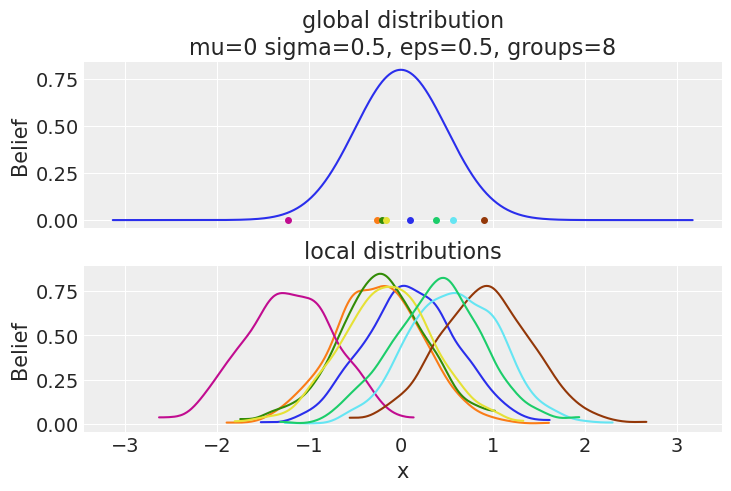

In [4]:
gen_hier_plot(mu = 0, sigma = 0.5 ,eps = 0.5)

Increasing the groups param simply increases the number of local distributions that we include, with smaller
eps the width of each of them is smaller. Even though their number is bigger, they don't overlap as much as in
the last example, on the same global distribution with.

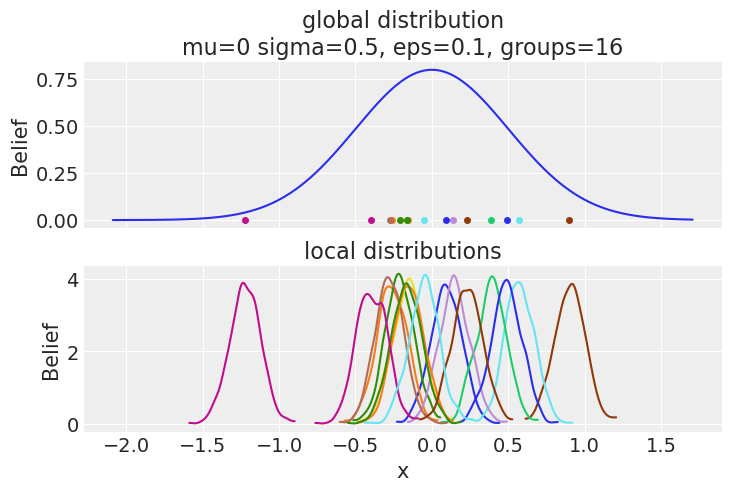

In [5]:
gen_hier_plot(mu = 0, sigma = 0.5, eps = 0.1, groups = 16)

Massive increase in sigma causes the global distribution to become very wide, what allows the local
distributions to spread out much more than in previous examples.

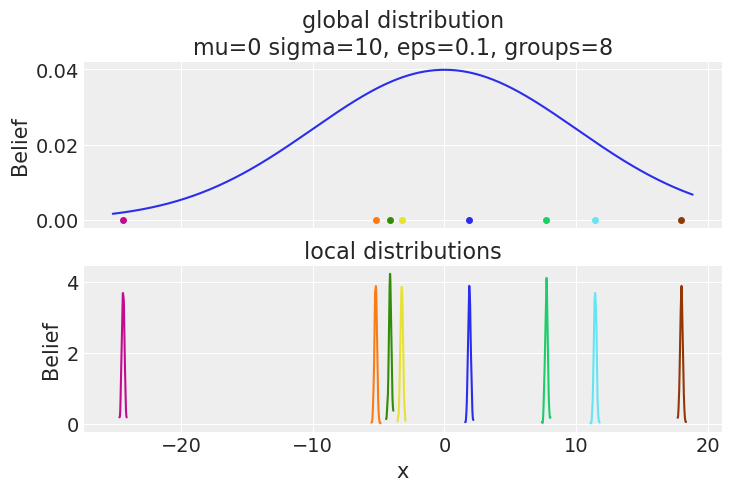

In [6]:
gen_hier_plot(mu = 0, sigma = 10, eps = 0.1)

Here exact oposite from previous example, having extremely tiny sigma causes all local dists to be pulled in. 

In a way this can be seen as having a very strong prior for a pooled model (all groups are the same) but considering a hierarchical model
if there is strong evidence on that end from the data.

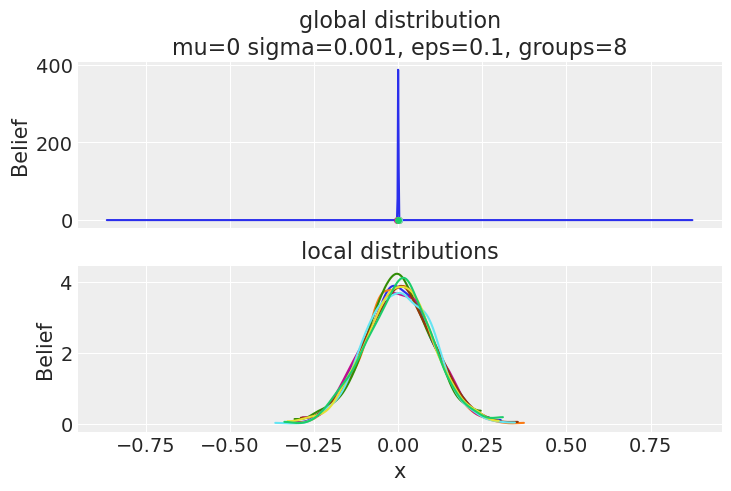

In [7]:
gen_hier_plot(mu = 0, sigma = 0.001, eps = 0.1)

## Exercise 3: Effect of group size on estimates

> We saw that for Perch, where we had few data, we get strong shrinkage while for Whitefish, where we had more data, we got less shrinkage. But how do these effects interact? In this exercise, you will explore this relationship more systematically. Towards this goal, you will create a plot where on the x-axis is the number of data points for a species, and on the y-axis is the beta estimate (with error bars reflecting posterior uncertainty) for that species. As we are interested in how strong the shrinkage is towards the global mean include the global beta mu (here you can just take the posterior mean) as a horizontal line (you can use `plt.axhline` for this).
>
> It is interesting to compare this to the unpooled model where the shrinkage should be much weaker (and towards 0 instead of towards global mean) so create the same plot for the unpooled model.
>
> What do you see in terms of how strong shrinkage is in relation to how much data we have per species? Does this make sense? Describe the effect in your own words!

In [8]:
with pm.Model(coords=COORDS) as unpooled_intercept_unpooled_beta:
    # data, here we won't be generating predictions so we use ConstantData
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_reduced.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    # priors
    intercept = pm.Normal("intercept", sigma=1.0, dims="species")
    β = pm.Normal("β", sigma=0.5, dims="species")
    
    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width

    # observational noise
    sigma = pm.HalfNormal("sigma", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=sigma,
        observed=log_weight,
    )

    # sampling
    idata_unpooled_intercept_unpooled_beta = pm.sample()


with pm.Model(coords=COORDS) as hierarchical_intercept_hierarchical_beta:
    # data
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_reduced.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)
    
    # global priors for intercepts
    intercept_mu = pm.Normal("intercept_mu", sigma=3.0)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=1.0)

    # individual intercepts for each species
    intercept = pm.Normal(
        "intercept",
        mu=intercept_mu,
        sigma=intercept_sigma, 
        dims="species"
    )
    
    # global prior for betas
    β_mu = pm.Normal("β_mu", sigma=3.0)
    β_sigma = pm.HalfNormal("β_sigma", sigma=1.0)

    # individual betas for each species
    β = pm.Normal("β", mu=β_mu, sigma=β_sigma, dims="species")
    
    # linear regression
    mu = intercept[species_idx_] + β[species_idx_] * log_width

    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )
    
    # Hit the Inference Button(TM)
    idata_hierarchical_intercept_hierarchical_beta = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β_mu, β_sigma, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


We write down a function to plot the mean and standard deviation we get from the posterior distribution of $\beta$ as color encoded
errorbar lines. Optionally it can also plot a horizontal line for the global mean (controled with the `global_mean` boolean arg).

In [9]:
_, species_count = np.unique(species_idx, return_counts=True)

def pooling_plot(idata, ax, global_mean):
    """Plot slope per species as errorbar.
    
    Parameters
    ----------
    idata : arviz.InferenceData
    ax : matplotlib.axes.Axes
    global_mean : boolean
        Indicates whether to plot the global mean as horizontal line across the graph.
    """
    posterior = idata.posterior
    mean = posterior["β"].mean(("chain", "draw"))
    std = posterior["β"].std(("chain", "draw"))

    for i, species_i in enumerate(species):
        color = sns.color_palette(n_colors = len(species))[i]
        ax.errorbar(
            species_count[i],
            mean.sel(species=species_i),
            yerr=std.sel(species=species_i),
            fmt="o",
            color=color,
            label=species_i,
        )

    if global_mean:
        global_mean = posterior["β_mu"].mean()
        ax.axhline(global_mean, color="k", lw=1, ls="--")
        ax.text(species_count.max(), global_mean-.01, r"Global β_mu", va="top", ha="right", color="k")
    ax.set(xlabel="Number of observed fish per species")

In order to address this last question:

> What do you see in terms of how strong shrinkage is in relation to how much data we have per species? Does this make sense? Describe the effect in your own words!

we will combine the two plots asked in the previous questions with an extra one, and lay them out in a 1x3 grid.

The left plot has the mean+std per species from the hierarchical model as errorbars, also with the global mean as a dashed horizontal line.
The center plot has the mean+std per species this time from the unpooled model, and no global mean (there isn't one in the model). 
Comparing them we see how for the hierarchical model, the means are less scattered around (as they are pulled towards the global mean by what we call the shrinkage effect) and also that in general, their standard deviations are smaller.

The right plot has the difference between means of each model. This can already be seen a bit in the two previous plots, but here we emphasize the magnitude of the shrinkage effect as a function of the number of observed species. We can clearly see how the differences between models are lower for species with more observations
and higher for species with less observations. For Perch for example, both models return basically the same result.

That being said, you need to be careful about assumptions on how many observations per group will render the shrinkage effect negligible as this will depend on
both the informativeness of the data and the chosen priors!

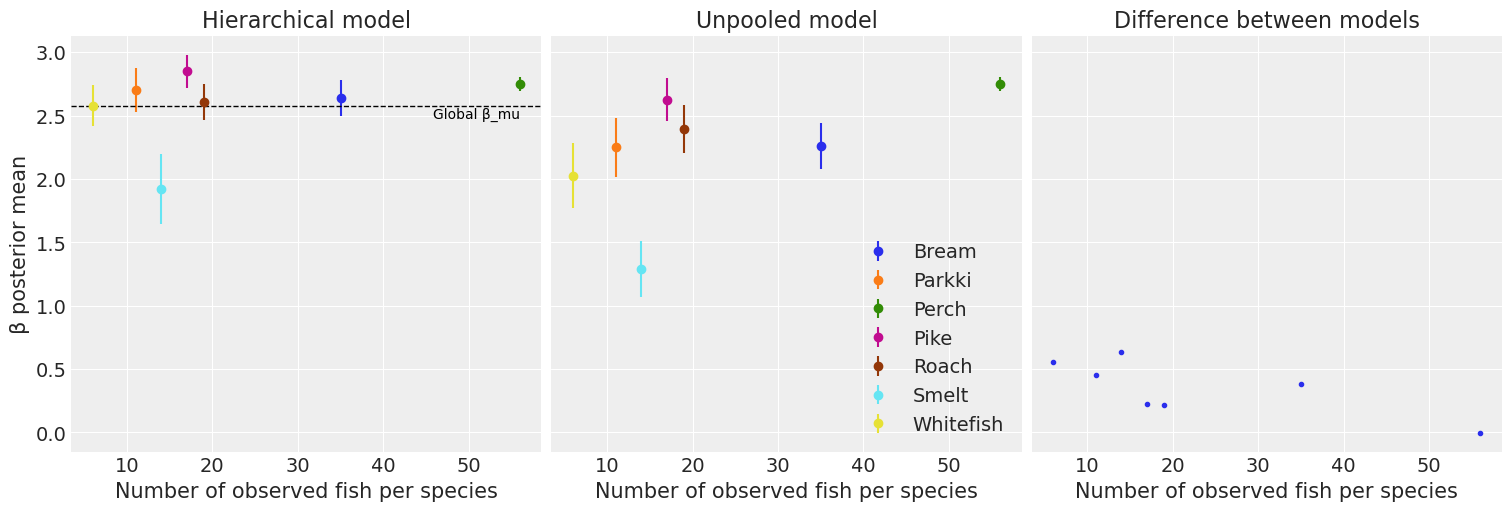

In [10]:
_, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
pooling_plot(idata_hierarchical_intercept_hierarchical_beta, axs[0], global_mean=True)
axs[0].set(title="Hierarchical model", ylabel="β posterior mean")
pooling_plot(idata_unpooled_intercept_unpooled_beta, axs[1], global_mean=False)
axs[1].legend()
axs[1].set_title("Unpooled model")
effect_difference = (
    idata_hierarchical_intercept_hierarchical_beta.posterior["β"].mean(("chain", "draw")) -
    idata_unpooled_intercept_unpooled_beta.posterior["β"].mean(("chain", "draw"))
)
axs[2].plot(species_count, effect_difference, ".")
axs[2].set(xlabel="Number of observed fish per species", title="Difference between models");

*tip*: you can use xarray plotting for quick basic visualizations

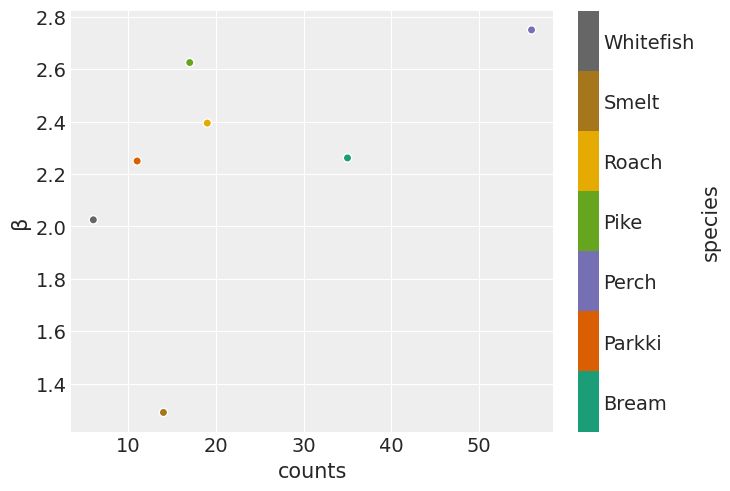

In [11]:
_, species_count = np.unique(species_idx, return_counts=True)
posterior = idata_unpooled_intercept_unpooled_beta.posterior.assign_coords(
    # add x values for plot as coordinate of species dimension
    counts=(("species",), species_count)
)
posterior["β"].mean(("chain", "draw")).plot.scatter(
    x="counts", hue="species", cmap="Dark2"
);

## Exercise 4: Unpooled, pooled, hierarchical variations

> Our linear regression model had 2 parameters (per species): an intercept and a beta (slope). In the lesson we put a hierarchy on both of these. However, we can mix and match freely and decide per parameter whether it should be pooled, unpooled, or hierarchical. All of these choices lead to different constraints on the parameters and that's what you'll explore in this exercise. Towards this goal, you will build different variations to get more familiarity with the code. Keep these models and idata objects around, however, as you will analyze the outputs in the next exercise.
> 
> Build the following versions of the model:
> 
> 1. Replace the hierarchy on the intercepts with a pooled style
> 1. Replace the hierarchy on the intercepts with an unpooled style
> 1. Replace the hierarchy on the slopes with a pooled style
> 1. Replace the hierarchy on the slopes with an unpooled style
>   
> Run each of these different models and make sure that everything converged well.

**4.1: Replace the hierarchy on the intercepts with a pooled style**

Starting for the hierarchical model above as template, we keep the $\beta$ as is and update the `intercept` to be a scalar.
That is all species have the same value for `intercept`, *we are pooling all the information into this single value*.

In [12]:
with pm.Model(coords = COORDS) as model_pooled_intercept_hierarchical_slopes:
    #data
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_reduced.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)
    # intercept
    intercept = pm.Normal("intercept", mu=5, sigma=1.0)
    
    # global β for all slopes
    β_mu = pm.Normal('β_mu', sigma = 3)
    β_sigma = pm.HalfNormal('β_sigma', sigma = 1)
    # individual betas for each slope
    β = pm.Normal("β", mu=β_mu, sigma=β_sigma, dims="species")
    
    # linear regression
    mu = intercept + β[species_idx_] * log_width
    
    # observational noise
    eps = pm.HalfNormal("eps", 1.0)

    # likelihood
    log_obs = pm.Normal(
        "log_obs",
        mu=mu,
        sigma=eps,
        observed=log_weight,
    )
    
    # Hit the Inference Button(TM)
    idata_pooled_intercept_hierarchical_slopes = pm.sample(target_accept=0.95)
    idata_pooled_intercept_hierarchical_slopes.extend(pm.sample_prior_predictive())
    idata_pooled_intercept_hierarchical_slopes.extend(pm.sample_posterior_predictive(idata_pooled_intercept_hierarchical_slopes))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_mu, β_sigma, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [eps, intercept, log_obs, β, β_mu, β_sigma]
Sampling: [log_obs]


Below we can see the graphviz representation of the model, which is a first debugging layer to ensure our model is written correctly.
We have also generated posterior, prior and posterior predictive samples which we could use for diagnostics (with for example `az.summary` or `az.plot_trace`),
or model checking (with for example `az.plot_ppc`).

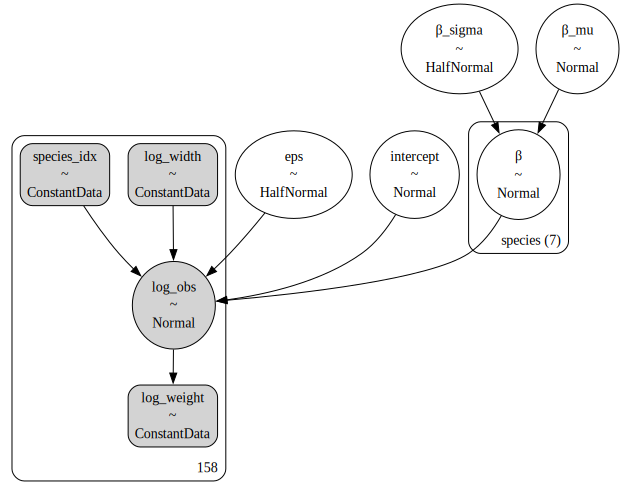

In [13]:
pm.model_to_graphviz(model_pooled_intercept_hierarchical_slopes)

As indicated in the wording, before using any posterior samples we should run some diagnostics. However, to prevent this notebook to be prohibitibely long we have only saved some of these checks for this model.

With `az.summary` we see that all ess estimates are large enough and rhat is 1 for all variables too.

In [14]:
az.summary(idata_pooled_intercept_hierarchical_slopes)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.649,0.057,1.542,1.757,0.002,0.001,759.0,1190.0,1.01
β_mu,2.678,0.121,2.438,2.889,0.003,0.002,1529.0,1116.0,1.00
β[Bream],2.800,0.038,2.722,2.866,0.001,0.001,877.0,1628.0,1.01
β[Parkki],2.826,0.064,2.707,2.944,0.002,0.001,1242.0,1990.0,1.00
β[Perch],2.578,0.039,2.508,2.655,0.001,0.001,864.0,1536.0,1.00
β[Pike],2.937,0.043,2.862,3.022,0.001,0.001,1080.0,1872.0,1.00
β[Roach],2.576,0.054,2.466,2.668,0.002,0.001,957.0,1605.0,1.00
β[Smelt],2.394,0.192,2.043,2.763,0.006,0.004,1066.0,1579.0,1.00
β[Whitefish],2.668,0.054,2.565,2.768,0.002,0.001,1260.0,2168.0,1.00
β_sigma,0.247,0.108,0.093,0.443,0.003,0.002,1617.0,2025.0,1.00


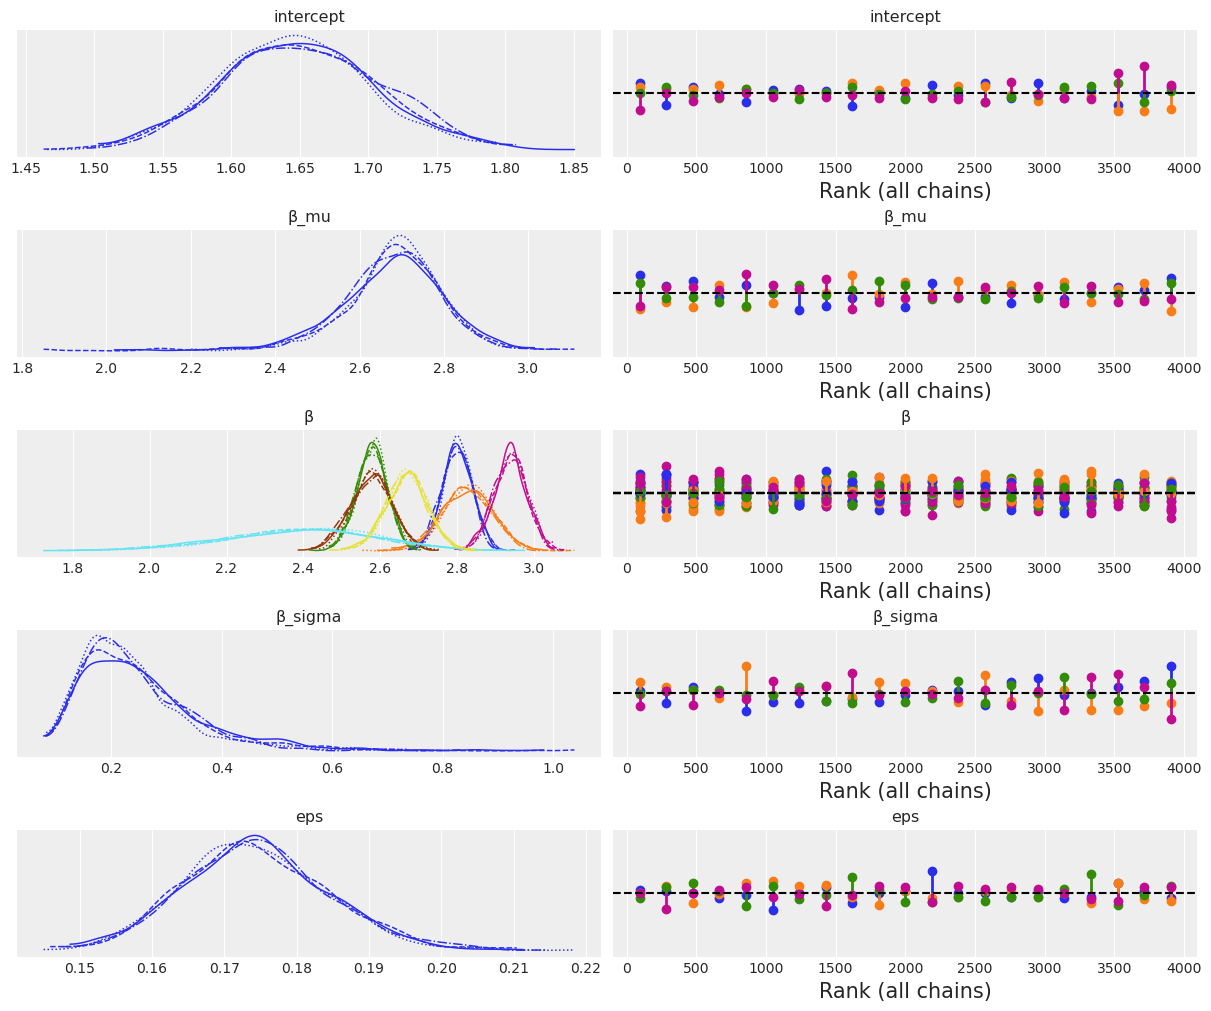

In [15]:
az.plot_trace(idata_pooled_intercept_hierarchical_slopes, kind="rank_vlines");

**4.2: Replace the hierarchy on the intercepts with an unpooled style**

Similar to above, we start from the same template, the hierarchical model above, but now we modify `intercept` to be unpooled.
That is, we generate a value for each species (with `dims="species"`) and there is no *sharing/pooling of information* between the
multiple `intercept`s.

In [16]:
with pm.Model(coords= COORDS) as model_unpooled_intercept_hierarchical_slopes:
    #data
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_weight = pm.ConstantData("log_weight", fish_reduced.log_weight.values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)
    
    #intercept
    intercept = pm.Normal('intercept', mu = 5, sigma = 1.0, dims='species')
    #global β params
    β_mu = pm.Normal('β_mu', mu = 0, sigma = 3)
    β_sigma = pm.HalfNormal('β_sigma', sigma = 1)
    
    #local betas
    β = pm.Normal('β', mu = β_mu, sigma = β_sigma, dims ='species')
    
    mu = intercept[species_idx_] + β[species_idx_] * log_width
    sigma = pm.HalfNormal('sigma', 1.0)
    
    likelihood = pm.Normal(
    'log_obs',
    mu = mu,
    sigma = sigma,
    observed = log_weight
    )
    
    idata_unpooled_intercept_hierarchical_slopes = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β_mu, β_sigma, β, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


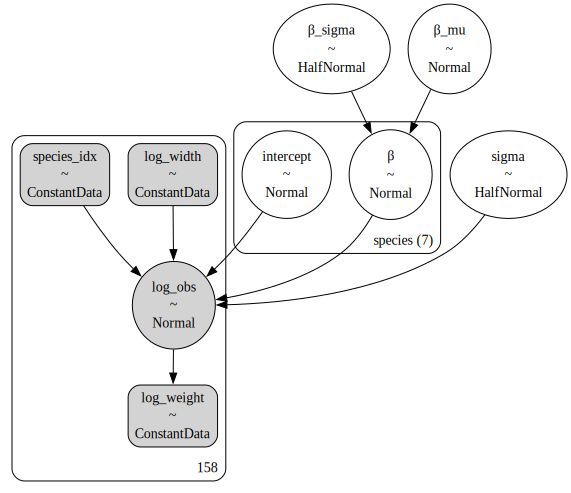

In [17]:
pm.model_to_graphviz(model_unpooled_intercept_hierarchical_slopes)

**4.3: Replace the hierarchy on the slopes with a pooled style**

We repeat the same process as in 4.1, but on the slopes $\beta$ instead of the `intercept`

In [18]:
with pm.Model(coords = COORDS) as model_hierarchical_intercept_pooled_slopes:
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_weight = pm.ConstantData("log_weight",fish_reduced.log_weight.values)
    species_idx_ = pm.ConstantData('species_idx', species_idx)
    
    #global priors for intercept
    intercept_mu = pm.Normal('intercept_mu', sigma =3.0)
    intercept_sigma = pm.HalfNormal('intercept_sigma', 1)
    # local intercept
    intercept = pm.Normal('intercept', mu = intercept_mu, sigma = intercept_sigma, dims = 'species')
    #slopes, pooled so no species dim
    β = pm.Normal('β', mu= 0, sigma = 1.0)
    
    mu = (
        intercept[species_idx_]
        + β * log_width
    )
    #noise
    sigma = pm.HalfNormal('sigma', 1.0)
    
    #likelihood
    likelihood = pm.Normal(
        'likelihood',
        mu = mu,
        sigma = sigma,
        observed = log_weight
    )

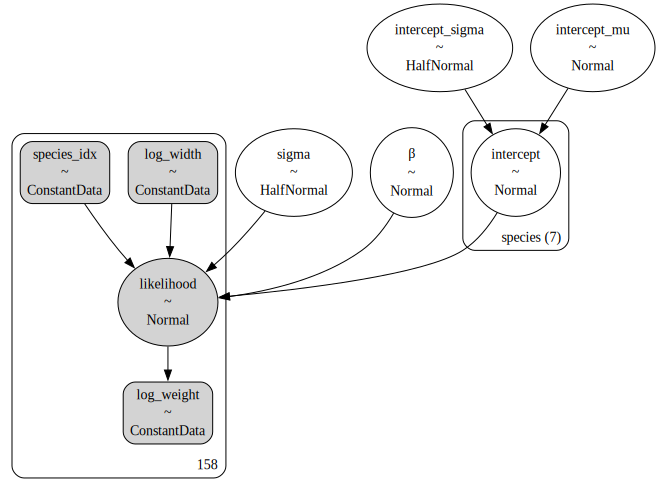

In [19]:
pm.model_to_graphviz(model_hierarchical_intercept_pooled_slopes)

In [20]:
with model_hierarchical_intercept_pooled_slopes:
    idata_hierarchical_intercept_pooled_slopes = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


**4.4: Replace the hierarchy on the slopes with an unpooled style**

In [21]:
with pm.Model(coords = COORDS) as model_hierarchical_intercept_unpooled_slopes:
    log_width = pm.ConstantData("log_width", fish_reduced.log_width.values)
    log_weight = pm.ConstantData("log_weight",fish_reduced.log_weight.values)
    species_idx_ = pm.ConstantData('species_idx', species_idx)
    
    
    #global priors for intercept
    intercept_mu = pm.Normal('intercept_mu', sigma =3.0)
    intercept_sigma = pm.HalfNormal('intercept_sigma', 1)
    # local intercept
    intercept = pm.Normal('intercept', mu = intercept_mu, sigma = intercept_sigma, dims = 'species')
    #slopes, unpooled so with species dim
    β = pm.Normal('β', mu= 0, sigma = 1.0, dims=('species'))
    
    mu = (
        intercept[species_idx_]
        + β[species_idx_] * log_width
    )
    #noise
    sigma = pm.HalfNormal('sigma', 1.0)
    
    #likelihood
    likelihood = pm.Normal(
        'likelihood',
        mu = mu,
        sigma = sigma,
        observed = log_weight
    )
    idata_hierarchical_intercept_unpooled_slopes = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_mu, intercept_sigma, intercept, β, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


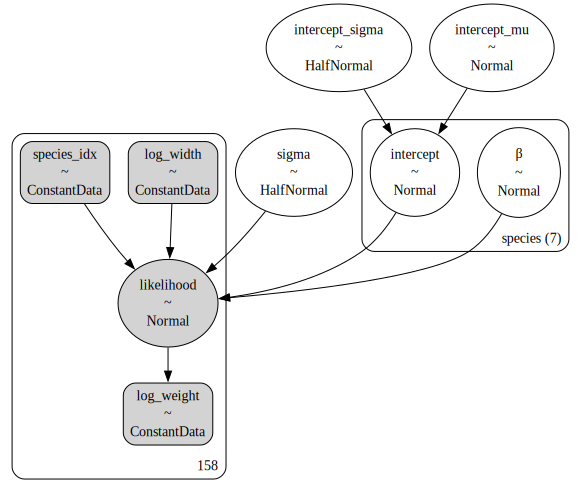

In [22]:
pm.model_to_graphviz(model_hierarchical_intercept_unpooled_slopes)

## Exercise 5: Effect of Hierarchy

> Let's examine what type of regression patterns these different models produce. For example, if you fix all slopes to be the same (i.e. pooled), but let the intercepts vary (i.e. hierarchical), how do you think the regression lines would look like?
>
> To find out, generate a plot where you plot all the regression lines of the different species in a single plot. If you were to include the uncertainty in this plot it would get too messy, so just the plot regression line for each species of the posterior mean.
>
> Now generate this plot for the different variants of the model you created in the previous exercise. What do you observe in each variant, what are the similarities and differences? Do the patterns make sense in terms of how the model is structured? Why?

In [23]:
import xarray as xr

def plot_pred(idata, ax, plot_multiple_draws=False, colors=None, title=""):
    """
    Helper function to plot regression lines from the posterior on top of data points.
    """
    x = xr.DataArray(np.linspace(0, 2.5, 150), dims=["x_plot"])
    post_mean = idata.posterior.mean(("chain", "draw"))
    y_mu = post_mean["intercept"] + x * post_mean["β"]
    
    if plot_multiple_draws:
        post_subset = az.extract(idata, num_samples=50)
        y_reg = post_subset["intercept"] + x * post_subset["β"]

    if colors is None:
        colors = sns.color_palette(n_colors = len(species))
        
    for i, species_i in enumerate(species):
        fish_spec = fish_reduced[fish_reduced.Species == species_i]
        ax.scatter(fish_spec["log_width"], fish_spec["log_weight"], color=colors[i])
        ax.plot(x, y_mu.sel(species=species_i), color=colors[i], alpha=0.5, lw=2, label=species_i)

        if plot_multiple_draws:
            ax.plot(x, y_reg.sel(species=species_i).transpose(..., "sample"), color=color, alpha=0.1)

    if title != "":
        ax.set_title(title)

    return ax

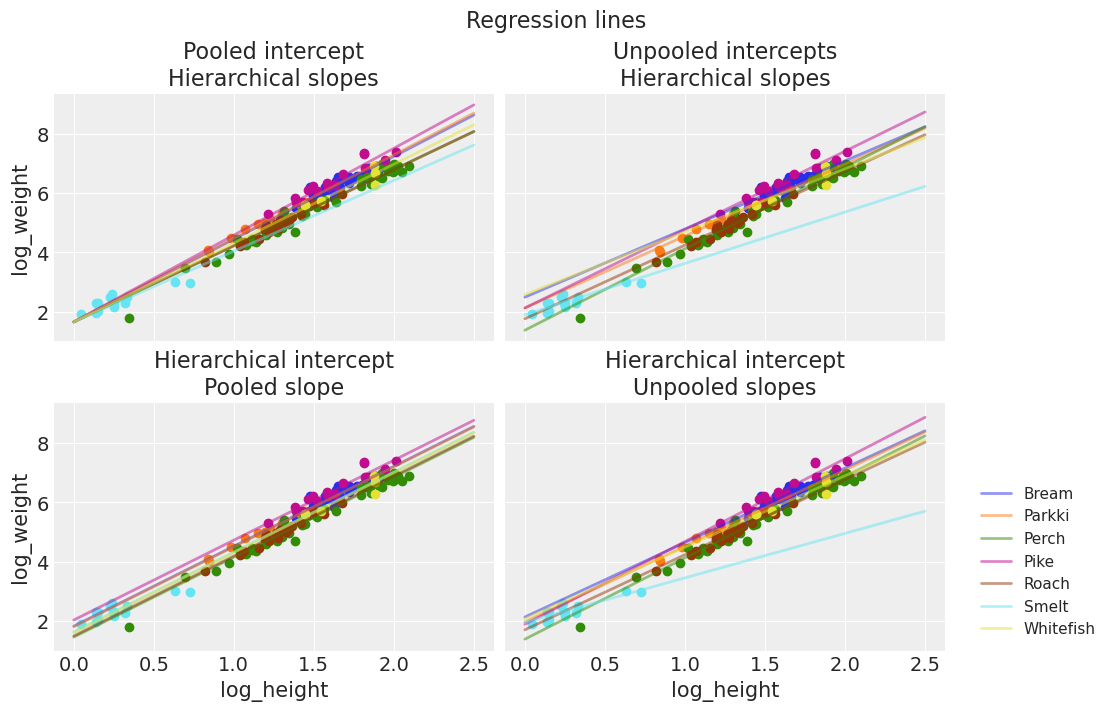

In [24]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(11, 7))

fig.suptitle("Regression lines", fontsize=16)

ax = axes[0, 0]
plot_pred(idata_pooled_intercept_hierarchical_slopes, ax=ax)
ax.set(title="Pooled intercept\nHierarchical slopes", ylabel="log_weight")

ax = axes[0, 1]
plot_pred(idata_unpooled_intercept_hierarchical_slopes, ax=ax)
ax.set(title="Unpooled intercepts\nHierarchical slopes")

ax = axes[1, 0]
plot_pred(idata_hierarchical_intercept_pooled_slopes, ax=ax)
ax.set(title="Hierarchical intercept\nPooled slope", ylabel="log_weight", xlabel="log_height")

ax = axes[1, 1]
plot_pred(idata_hierarchical_intercept_unpooled_slopes, ax=ax)
ax.set(title="Hierarchical intercept\nUnpooled slopes", xlabel="log_height")
ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', fontsize=11);

We have plotted our 4 models in a square grid, and used the same grid in height to plot the regression lines to try and ease the comparison between them.
However, as always, there are other ways to visualize those same effects.

In our 2x2 grid, the two plots in each row have had the same parameter modified, whereas plots sharing a column use the same hierarchy type but on different variables.

Thus, we can see how in the left column, with the pooled models, we have the same intercept for all lines (above) and the same slope for all lines (below).
In the right column we can see the unpooled models where there is no shrinkage effect. And indeed, out of all 4 plots, the upper right one with the unpooled intercept is the one with intercept values more spread out. And the lower right with unpooled slopes is the one with less similarities between the slopes of each line.